# Face Mask Detection

### Objetivo:
*   Detectar y clasificar si las personas en las imágenes están con mascarillas o sin mascarilla puesta

### Data:


*   All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530).





In [ ]:
import numpy as np
import sympy as sp

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, Lambda, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.losses import BinaryCrossentropy            #Función de costo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:

!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 59 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
#carpeta de imágenes
!unzip Facemask.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Facemask/Train/WithoutMask/1855.png  
  inflating: Facemask/Train/WithoutMask/1856.png  
  inflating: Facemask/Train/WithoutMask/1857.png  
  inflating: Facemask/Train/WithoutMask/1858.png  
  inflating: Facemask/Train/WithoutMask/1859.png  
  inflating: Facemask/Train/WithoutMask/1860.png  
  inflating: Facemask/Train/WithoutMask/1861.png  
  inflating: Facemask/Train/WithoutMask/1862.png  
  inflating: Facemask/Train/WithoutMask/1863.png  
  inflating: Facemask/Train/WithoutMask/1864.png  
  inflating: Facemask/Train/WithoutMask/1865.png  
  inflating: Facemask/Train/WithoutMask/1866.png  
  inflating: Facemask/Train/WithoutMask/1867.png  
  inflating: Facemask/Train/WithoutMask/1868.png  
  inflating: Facemask/Train/WithoutMask/1869.png  
  inflating: Facemask/Train/WithoutMask/1870.png  
  inflating: Facemask/Train/WithoutMask/1871.png  
  inflating: Facemask/Train/WithoutMask/1872.png  
  inflating: Facemask

### Distribución (with/without mask):


*   Train: 5000/5000
*   Validation: 400/400
*   Test: 483/509

In [ ]:
import sys
import cv2
import glob
import numpy as np
import pickle as cPickle
import time
import random
import scipy.cluster.vq as vq
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def prepareFiles(rootpath):
	current_GT_id=0
	filenames=[]
	GT_ids=[]
	GT_labels=[]
	classpath = sorted(glob.glob(rootpath+'*'))
	for i in classpath:
		filespath = sorted(glob.glob(i+'/*.png'))
		for j in filespath:
			filenames.append(j)
			GT_ids.append(current_GT_id)
			GT_labels.append(i.split('/')[-1])
		current_GT_id+=1
	return(filenames,GT_ids,GT_labels)

In [ ]:
# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_train='./Facemask/Train/'

# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_valid='./Facemask/Validation/'

# Directorio raiz donde se encuentran todas las imágenes de test
dataset_folder_test='./Facemask/Test/'

In [ ]:
# Separación de train, valid, test
# Cálculo de puntos de interés para todas las imágenes del conjunto de aprendizaje
filenames_train,GT_ids_train,GT_labels_train = prepareFiles(dataset_folder_train)
filenames_valid,GT_ids_valid,GT_labels_valid = prepareFiles(dataset_folder_valid)
filenames_test,GT_ids_test,GT_labels_test = prepareFiles(dataset_folder_test)


#filenames_train: contiene todas las imágenes de train
#GT_ids_train: contiene las clases a la que pertenecen cada imagen
#GT_labels_train: son las etiquetas de cada clase de imágen

In [ ]:
filenames_train[9999]

'./Facemask/Train/WithoutMask/997.png'

In [ ]:
GT_ids_train[0]

0

In [ ]:
#Train: Usando solo 1600 imágenes: 800 de with y 800 de without
filenames_train = filenames_train[0:800]+filenames_train[9199:9999]
GT_ids_train = GT_ids_train[0:800]+GT_ids_train[9199:9999]

#Valid: Usando solo 400 imágenes: 200 de with y 200 de without
filenames_valid = filenames_valid[0:200]+filenames_valid[599:799]
GT_ids_valid = GT_ids_valid[0:200]+GT_ids_valid[599:799]

In [ ]:
def getKeypointsDescriptors(filenames):
  A=[]
  print('Obtaining the images matrix from the filenames')
  init=time.time()
  for filename in filenames:
    ima=cv2.imread(filename)
    #ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
    ima = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    dim = (256, 256)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA)
    A.append(ima)
  end=time.time()
  print('Done in '+str(end-init)+' secs.')
  return(A)

In [ ]:
#Train:
X_train = getKeypointsDescriptors(filenames_train)
y_train = GT_ids_train 

#Validation:
X_valid = getKeypointsDescriptors(filenames_valid)
y_valid = GT_ids_valid 

#Test:
X_test = getKeypointsDescriptors(filenames_test)
y_test = GT_ids_test

Obtaining the images matrix from the filenames
Done in 0.907036542892456 secs.
Obtaining the images matrix from the filenames
Done in 0.35936880111694336 secs.
Obtaining the images matrix from the filenames
Done in 1.7285122871398926 secs.


In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
import numpy as np
np.unique(y_train)

#Clasificador binario -> No es necesario one hot encoder

array([0, 1])

In [ ]:
X_train.shape

(1600, 256, 256)

In [ ]:
X_train.shape[1:]

(256, 256)

In [ ]:
# Tamaños (With and Wuthout mask)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_valid.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# Número de datos de entrenamiento y de prueba
ntrain = X_train.shape[0]
nvalid = X_valid.shape[0]
ntest = X_test.shape[0]

# Tamaño de la imagen
npx = X_train.shape[1] 

Tamaño del conjunto de entrenamiento: (1600, 256, 256)
Tamaño del conjunto de validación: (400, 256, 256)
Tamaño del conjunto de prueba: (992, 256, 256)


Mostrando 3 imágenes de ejemplos

In [ ]:

class_names = ['Wearing mask', 'No wearing mask']

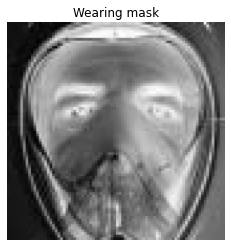

In [ ]:
#mostrar imagen
idx = 0
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off') 
plt.show()


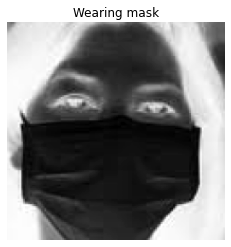

In [ ]:
#mostrar imagen
idx = 510
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off') 
plt.show()

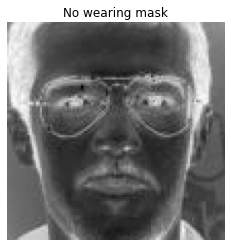

In [ ]:
#mostrar imagen
idx = 804
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')
plt.show()

Preprocesamiento:

In [ ]:
# Aumentar 1 dimension para que esté en formato que acepta Keras (escala a grises)
X_train = X_train.reshape(ntrain, npx, npx, 1) 
X_valid = X_valid.reshape(nvalid, npx, npx, 1)
X_test = X_test.reshape(ntest, npx, npx, 1)   

print("Tamaño modificado del conjunto de entrenamiento:", X_train.shape)
print("Tamaño modificado del conjunto de validacion:", X_valid.shape)
print("Tamaño modificado del conjunto de prueba:", X_test.shape)

Tamaño modificado del conjunto de entrenamiento: (1600, 256, 256, 1)
Tamaño modificado del conjunto de validacion: (400, 256, 256, 1)
Tamaño modificado del conjunto de prueba: (992, 256, 256, 1)


In [ ]:
#Normalizando
X_train = X_train/255.        # . -> float
X_valid = X_valid/255.
X_test = X_test/255.

In [ ]:
X_train.shape

(1600, 256, 256, 1)

In [ ]:
X_train.shape[1]

256

# Creando nuestra CNN

## VGG-16


In [ ]:
model = Sequential()
# Generación de 256x256x1:
model.add(Conv2D(input_shape=(256,256,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))   # 64 filtros de 3x3x1, con padding
# Generación de 256x256x64:
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))   # 64 filtros de 3x3x64, con padding
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# Generación de 112x112x64:
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))              #Pool de grupos de 2x2 escoger un max, pasar con s=2(paso)
# Generación de 112x112x128:
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))    # 128 filtros de 3x3x64
# Generación de 112x112x128:
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

# Generación de 56x56x128:
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# Generación de 56x56x256:
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# Generación de 56x56x256:
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# Generación de 56x56x256:
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

# Generación de 28x28x256:
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# Generación de 28x28x512:
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# Generación de 28x28x512:
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# Generación de 28x28x512:
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

# Generación de 14x14x512:
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# Generación de 14x14x512:
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# Generación de 14x14x512:
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# Generación de 14x14x512:
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

# Generación de 7x7x512:
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                  

# Creando Red Neuronal

In [ ]:
# DNN-1
model.add(Flatten())     # entran 256x256x1 datos a cada neurona
                 
model.add(Dense(4096))
model.add(BatchNormalization())         #proporciona una mejor regularizacion y mejorar el accuracy
model.add(Activation('swish'))         
model.add(Dropout(0.5))             #borra aleatoriamente la mitad de las neuronas de esta capa con cada iteración
                                          #dropout sirve para evitar la memorización de datos(overfitting)

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=BinaryCrossentropy(),
             optimizer=Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                  

Regularization

In [ ]:
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'       #para almacenar cada mejor modelo encontrado con con cada iteracion

cp = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss',
                     verbose=1, 
                     save_best_only=True,
                     mode='min')
#el checkpoint(cp) guardará los parámetros del modelo que generen el mínimo de 'val_loss' y se quedará con esos hasta que aparezca un menor a loss

es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   mode='min',
                   verbose=0,
                   restore_best_weights=True)
# si "es" detecta 10 veces seguidas que el 'val_loss' está subiendo(malo) entonces parará las iteraciones

pl = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patince=5,
                       verbose=0,
                       mode='min')
#reduce(multiplica) al 'learning_rate' en un factor de 0.2 cada 5 veces seguidas que el val_loss se reduzca

Model fitting

In [ ]:
history = model.fit(x=X_train,
          y=y_train,
          batch_size=10,
          epochs=15,
          validation_data=(X_valid, y_valid),
          shuffle=True,
          verbose=True,
          callbacks=[cp, es, pl]
         )

#batch_size: define la cantidad de subgrupos a entrenar del grupo total
#si tengo 1000 datos, debo hacer un batch_size multiplo de aquel valor -> 10 o 100

Epoch 1/15
160/160 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.7487
Epoch 00001: val_loss improved from inf to 0.38231, saving model to ./my_best_model.epoch01-loss0.38.hdf5
160/160 [==============================] - 94s 577ms/step - loss: 0.5260 - accuracy: 0.7487 - val_loss: 0.3823 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 2/15
160/160 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8988
Epoch 00002: val_loss did not improve from 0.38231
160/160 [==============================] - 82s 513ms/step - loss: 0.3499 - accuracy: 0.8988 - val_loss: 2.6490 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 3/15
160/160 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.9194
Epoch 00003: val_loss improved from 0.38231 to 0.27109, saving model to ./my_best_model.epoch03-loss0.27.hdf5
160/160 [==============================] - 93s 579ms/step - loss: 0.2706 - accuracy: 0.9194 - val_loss: 0.2711 - val_accuracy: 0.8825 - lr: 0.0010
Epoc

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
import matplotlib.pyplot as plt

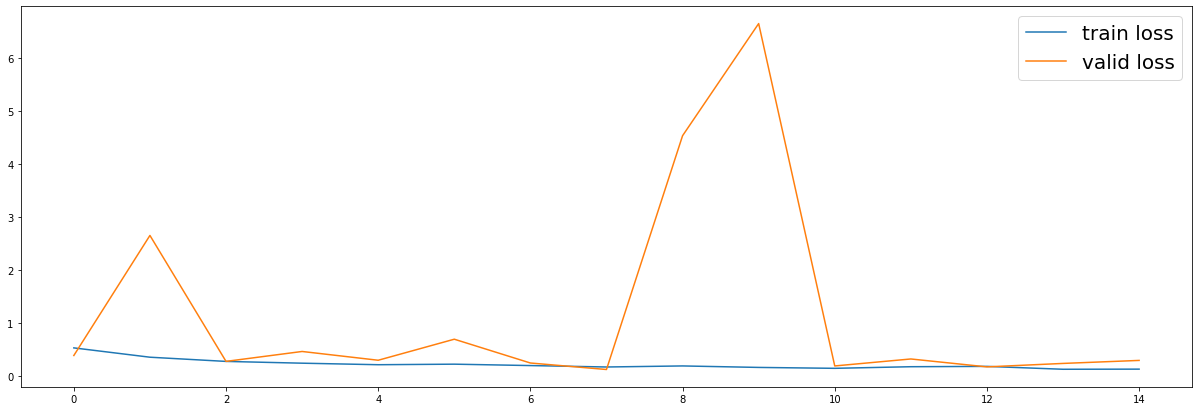

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend(fontsize=20)
plt.show()

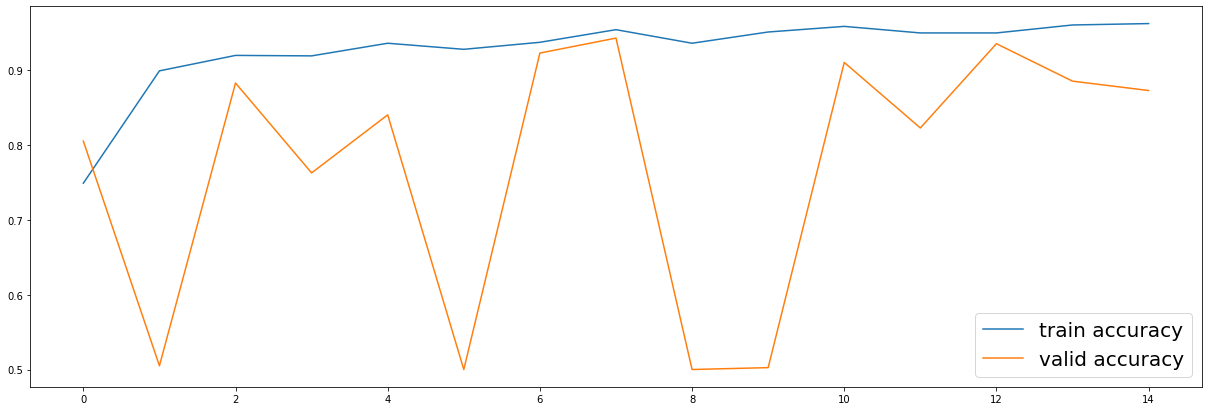

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend(fontsize=20)
plt.show()

### Matriz de Confusión

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize = (10, 10), text_size=15):
  # create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)

  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title='Confusion Matrix',
        xlabel='Predicted Label',
        ylabel='True Label',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)
  # Set x-axis  labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min())/2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)", 
            horizontalalignment='center',
            color='white' if cm[i, j] > threshold else 'black',
            size=text_size)

In [ ]:
class_names

['Wearing mask', 'No wearing mask']

In [ ]:
class_names[int(np.round(y_probs[231],0))]

'No wearing mask'

In [ ]:
y_preds = []

for i in range(len(y_probs)):
  y_pred = int(np.round(y_probs[i],0))  
  y_preds.append(y_pred)

In [ ]:
confusion_matrix(y_true=y_test, y_pred=y_preds)

array([[346, 137],
       [  3, 506]])

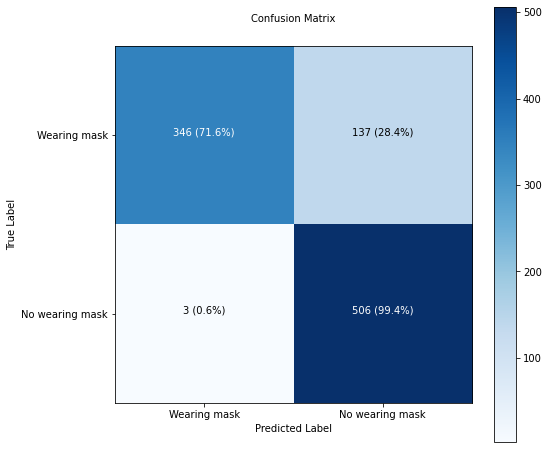

In [ ]:
make_confusion_matrix(y_true=y_test,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize = (8, 8),
                      text_size=10)